In [39]:
# Imports 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Load and diaplay the dataset
df = pd.read_csv("/Users/alexandraaustin/DS3000-Group-11/Airline_Delay_Cause.csv")
print(df.head())

   year  month carrier       carrier_name airport  arr_flights  arr_del15  \
0  2023      8      9E  Endeavor Air Inc.     ABE         89.0       13.0   
1  2023      8      9E  Endeavor Air Inc.     ABY         62.0       10.0   
2  2023      8      9E  Endeavor Air Inc.     AEX         62.0       10.0   
3  2023      8      9E  Endeavor Air Inc.     AGS         66.0       12.0   
4  2023      8      9E  Endeavor Air Inc.     ALB         92.0       22.0   

   carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  \
0        2.25        1.60    3.16          0.0              5.99   
1        1.97        0.04    0.57          0.0              7.42   
2        2.73        1.18    1.80          0.0              4.28   
3        3.69        2.27    4.47          0.0              1.57   
4        7.76        0.00    2.96          0.0             11.28   

   arr_cancelled  arr_diverted  arr_delay  carrier_delay  weather_delay  \
0            2.0           1.0     1375.0           7

In [7]:
# Display basic statistics and inspect missing data
print(df.info())
print(df.describe(include="all"))
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171223 entries, 0 to 171222
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 171223 non-null  int64  
 1   month                171223 non-null  int64  
 2   carrier              171223 non-null  object 
 3   carrier_name         171223 non-null  object 
 4   airport              171223 non-null  object 
 5   arr_flights          171223 non-null  float64
 6   arr_del15            171223 non-null  float64
 7   carrier_ct           171223 non-null  float64
 8   weather_ct           171223 non-null  float64
 9   nas_ct               171223 non-null  float64
 10  security_ct          171223 non-null  float64
 11  late_aircraft_ct     171223 non-null  float64
 12  arr_cancelled        171223 non-null  float64
 13  arr_diverted         171223 non-null  float64
 14  arr_delay            171223 non-null  float64
 15  carrier_delay    

In [14]:
# Drop rows with missing key columns needed for target/label creation
df = df.dropna(subset=["arr_delay", "arr_flights", "arr_del15"]).reset_index(drop=True)

# Remove rows where arr_flights is zero to avoid division by zero
df = df[df["arr_flights"] > 0].reset_index(drop=True)

# Create delay_rate feature (fraction of flights delayed >=15 minutes)
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]

print("Dataset shape after cleaning:", df.shape)
print(df.head())


Regression feature matrix shape: (171223, 450)
Classification feature matrix shape: (171223, 450)
Proportion of High_Delay = 1: 0.2211443556064314


In [11]:
# One-hot encode categorical features
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("\nCategorical columns:", list(cat_cols))

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head()


Categorical columns: ['carrier', 'carrier_name', 'airport']


,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,...,airport_VLD,airport_VPS,airport_WRG,airport_WYS,airport_XNA,airport_XWA,airport_YAK,airport_YKM,airport_YNG,airport_YUM
0,2023,8,89.0,13.0,2.25,1.60,3.16,0.0,5.99,2.0,...,False,False,False,False,False,False,False,False,False,False
1,2023,8,62.0,10.0,1.97,0.04,0.57,0.0,7.42,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2023,8,62.0,10.0,2.73,1.18,1.80,0.0,4.28,1.0,...,False,False,False,False,False,False,False,False,False,False
3,2023,8,66.0,12.0,3.69,2.27,4.47,0.0,1.57,1.0,...,False,False,False,False,False,False,False,False,False,False
4,2023,8,92.0,22.0,7.76,0.00,2.96,0.0,11.28,2.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Create target variables 
X_reg = df_encoded.drop("arr_delay", axis=1)
y_reg = df_encoded["arr_delay"]

# Classification target: high vs low delay_rate
delay_rate_threshold = 0.25   # 25% of flights delayed >= 15 minutes
df_encoded["High_Delay"] = (df["delay_rate"] > delay_rate_threshold).astype(int)

X_cls = df_encoded.drop("High_Delay", axis=1)
y_cls = df_encoded["High_Delay"]

In [23]:
# Split the data into train, validation, and test
X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(
    X_temp_reg, y_temp_reg, test_size=(1/3), random_state=42
)

# With stratification for classification
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=42, stratify=y_cls
)

X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(
    X_temp_cls, y_temp_cls, test_size=(1/3), random_state=42, stratify=y_temp_cls
)

In [24]:
# Normalize the data
# Regression scaler
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_val_reg_scaled = scaler_reg.transform(X_val_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Classification scaler
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_val_cls_scaled = scaler_cls.transform(X_val_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

In [25]:
# Linear Regression Model
start_lr = time.time()

lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

y_val_pred_lr = lr_model.predict(X_val_reg_scaled)
y_test_pred_lr = lr_model.predict(X_test_reg_scaled)

end_lr = time.time()
time_lr = end_lr - start_lr

lr_r2_val = r2_score(y_val_reg, y_val_pred_lr)
lr_rmse_val = np.sqrt(mean_squared_error(y_val_reg, y_val_pred_lr))

lr_r2_test = r2_score(y_test_reg, y_test_pred_lr)
lr_rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_lr))

print("\nLinear Regression (Validation):")
print("R-squared: %.4f" % lr_r2_val)
print("RMSE: %.4f" % lr_rmse_val)

print("\nLinear Regression (Test):")
print("R-squared: %.4f" % lr_r2_test)
print("RMSE: %.4f" % lr_rmse_test)

print("Training + prediction time (s): %.4f" % time_lr)


Linear Regression (Validation):
R-squared: 1.0000
RMSE: 2.4942

Linear Regression (Test):
R-squared: 1.0000
RMSE: 0.2508
Training + prediction time (s): 1.8434


In [30]:
# Random Forest Regression Model
start_rf_reg = time.time()

rf_reg = RandomForestRegressor(n_estimators=5, max_depth=10, random_state=42)

rf_reg.fit(X_train_reg_scaled, y_train_reg)

y_val_pred_rf_reg = rf_reg.predict(X_val_reg_scaled)
y_test_pred_rf_reg = rf_reg.predict(X_test_reg_scaled)

end_rf_reg = time.time()
time_rf_reg = end_rf_reg - start_rf_reg

rf_r2_val = r2_score(y_val_reg, y_val_pred_rf_reg)
rf_rmse_val = np.sqrt(mean_squared_error(y_val_reg, y_val_pred_rf_reg))

rf_r2_test = r2_score(y_test_reg, y_test_pred_rf_reg)
rf_rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_rf_reg))

print("\nRandom Forest Regressor (Validation):")
print("R-squared: %.4f" % rf_r2_val)
print("RMSE: %.4f" % rf_rmse_val)

print("\nRandom Forest Regressor (Test):")
print("R-squared: %.4f" % rf_r2_test)
print("RMSE: %.4f" % rf_rmse_test)

print("Training + prediction time (s): %.4f" % time_rf_reg)


Random Forest Regressor (Validation):
R-squared: 0.9898
RMSE: 1353.7154

Random Forest Regressor (Test):
R-squared: 0.9947
RMSE: 858.6240
Training + prediction time (s): 6.7949


In [32]:
# Compare Regression Models
print("\nRegression model comparison (Test set):")
print("Linear Regression -> R²: %.4f, RMSE: %.4f, Time: %.4f s" %
      (lr_r2_test, lr_rmse_test, time_lr))
print("Random Forest Regressor -> R²: %.4f, RMSE: %.4f, Time: %.4f s" %
      (rf_r2_test, rf_rmse_test, time_rf_reg))


Regression model comparison (Test set):
Linear Regression -> R²: 1.0000, RMSE: 0.2508, Time: 1.8434 s
Random Forest Regressor -> R²: 0.9947, RMSE: 858.6240, Time: 6.7949 s


In [33]:
# Logistic Regression Classification Model
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

start_log = time.time()
log_reg.fit(X_train_cls_scaled, y_train_cls)
y_val_pred_log = log_reg.predict(X_val_cls_scaled)
y_test_pred_log = log_reg.predict(X_test_cls_scaled)
end_log = time.time()
time_log = end_log - start_log

acc_val_log = accuracy_score(y_val_cls, y_val_pred_log)
f1_val_log = f1_score(y_val_cls, y_val_pred_log)
rec_val_log = recall_score(y_val_cls, y_val_pred_log)
prec_val_log = precision_score(y_val_cls, y_val_pred_log)

acc_test_log = accuracy_score(y_test_cls, y_test_pred_log)
f1_test_log = f1_score(y_test_cls, y_test_pred_log)
rec_test_log = recall_score(y_test_cls, y_test_pred_log)
prec_test_log = precision_score(y_test_cls, y_test_pred_log)

print("\nLogistic Regression (Validation):")
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_log))
print("Accuracy: %.4f" % acc_val_log)
print("F1-score: %.4f" % f1_val_log)
print("Recall: %.4f" % rec_val_log)
print("Precision: %.4f" % prec_val_log)

print("\nLogistic Regression (Test):")
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_log))
print("Accuracy: %.4f" % acc_test_log)
print("F1-score: %.4f" % f1_test_log)
print("Recall: %.4f" % rec_test_log)
print("Precision: %.4f" % prec_test_log)

print("Training + prediction time (s): %.4f" % time_log)


Logistic Regression (Validation):
Confusion Matrix:
 [[26652    19]
 [   83  7490]]
Accuracy: 0.9970
F1-score: 0.9932
Recall: 0.9890
Precision: 0.9975

Logistic Regression (Test):
Confusion Matrix:
 [[13328     8]
 [   39  3748]]
Accuracy: 0.9973
F1-score: 0.9938
Recall: 0.9897
Precision: 0.9979
Training + prediction time (s): 5.3235


In [34]:
# Random Forest Classification Model
rf_cls = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

start_rf_cls = time.time()
rf_cls.fit(X_train_cls_scaled, y_train_cls)
y_val_pred_rf = rf_cls.predict(X_val_cls_scaled)
y_test_pred_rf = rf_cls.predict(X_test_cls_scaled)
end_rf_cls = time.time()
time_rf_cls = end_rf_cls - start_rf_cls

acc_val_rf = accuracy_score(y_val_cls, y_val_pred_rf)
f1_val_rf = f1_score(y_val_cls, y_val_pred_rf)
rec_val_rf = recall_score(y_val_cls, y_val_pred_rf)
prec_val_rf = precision_score(y_val_cls, y_val_pred_rf)

acc_test_rf = accuracy_score(y_test_cls, y_test_pred_rf)
f1_test_rf = f1_score(y_test_cls, y_test_pred_rf)
rec_test_rf = recall_score(y_test_cls, y_test_pred_rf)
prec_test_rf = precision_score(y_test_cls, y_test_pred_rf)

print("\nRandom Forest Classifier (Validation):")
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_rf))
print("Accuracy: %.4f" % acc_val_rf)
print("F1-score: %.4f" % f1_val_rf)
print("Recall: %.4f" % rec_val_rf)
print("Precision: %.4f" % prec_val_rf)

print("\nRandom Forest Classifier (Test):")
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_rf))
print("Accuracy: %.4f" % acc_test_rf)
print("F1-score: %.4f" % f1_test_rf)
print("Recall: %.4f" % rec_test_rf)
print("Precision: %.4f" % prec_test_rf)

print("Training + prediction time (s): %.4f" % time_rf_cls)


Random Forest Classifier (Validation):
Confusion Matrix:
 [[26671     0]
 [    0  7573]]
Accuracy: 1.0000
F1-score: 1.0000
Recall: 1.0000
Precision: 1.0000

Random Forest Classifier (Test):
Confusion Matrix:
 [[13336     0]
 [    0  3787]]
Accuracy: 1.0000
F1-score: 1.0000
Recall: 1.0000
Precision: 1.0000
Training + prediction time (s): 13.9943


In [35]:
# Compare Classification Models
print("\nClassification model comparison (Test set):")
print("Logistic Regression -> Acc: %.4f, F1: %.4f, Recall: %.4f, Precision: %.4f, Time: %.4f s" %
      (acc_test_log, f1_test_log, rec_test_log, prec_test_log, time_log))
print("Random Forest Classifier -> Acc: %.4f, F1: %.4f, Recall: %.4f, Precision: %.4f, Time: %.4f s" %
      (acc_test_rf, f1_test_rf, rec_test_rf, prec_test_rf, time_rf_cls))



Classification model comparison (Test set):
Logistic Regression -> Acc: 0.9973, F1: 0.9938, Recall: 0.9897, Precision: 0.9979, Time: 5.3235 s
Random Forest Classifier -> Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, Time: 13.9943 s



Top 10 features by importance (Random Forest Regressor):
arr_del15              0.751050
late_aircraft_delay    0.182057
carrier_delay          0.035392
nas_delay              0.017544
nas_ct                 0.007946
weather_delay          0.002687
weather_ct             0.000959
arr_cancelled          0.000586
carrier_ct             0.000369
security_ct            0.000254
dtype: float64


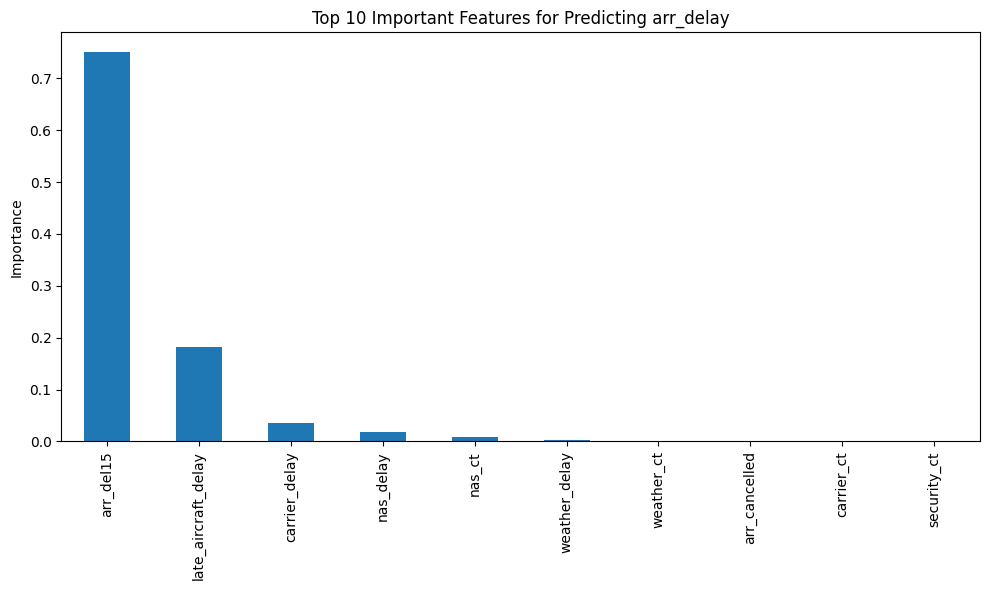

In [40]:
# Feature Importance from Random Forest Classifier
importances = rf_reg.feature_importances_
feature_names = X_reg.columns

feat_importances = pd.Series(importances, index=feature_names)
feat_importances_sorted = feat_importances.sort_values(ascending=False)

print("\nTop 10 features by importance (Random Forest Regressor):")
print(feat_importances_sorted.head(10))

plt.figure(figsize=(10, 6))
feat_importances_sorted.head(10).plot(kind="bar")
plt.title("Top 10 Important Features for Predicting arr_delay")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()